In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
(188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tab20 = [tuple([float(c)/255.0 for c in t]) for t in tableau20]

In [3]:
pruning='0.3'

In [4]:
bud_df = pd.read_csv('/Users/joel/Projects/sep-multi2/opti-bud.csv',names=['e','n','bud_number','size','bud_percentage','mean_budtime'])
net_df = pd.read_csv('/Users/joel/Projects/sep-multi2/opti-net'+pruning+'.csv',header=0)




IOError: File /Users/joel/Projects/sep-multi2/opti-bud.csv does not exist

In [ ]:
len(net_df.columns.values.tolist())

In [ ]:
cols = [x for i,x in enumerate(net_df.columns.values.tolist()) if i!=2 and i<18]

In [ ]:
net_df = net_df.drop_duplicates(cols)

In [ ]:
for c in bud_df.columns:
    bud_df[c] = bud_df[c].astype(float)
for c in net_df.columns:
    net_df[c] = net_df[c].astype(float)

In [ ]:
# net_df.head(5)

In [ ]:
criticalRegion = bud_df.query('bud_percentage > 0.2 & bud_percentage < 0.8 & e*n < 320')[['e','n']].values.tolist()
criticalNets = pd.DataFrame(columns=net_df.columns)
for c in criticalRegion:
    runNets = net_df[(net_df['Mean Affinity']==c[1]) & (net_df['Ligand Number']==c[0])]
    criticalNets = criticalNets.append(runNets)

In [297]:
bud_df = None
net_df = None

In [315]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity','Ligand Number']).mean().reset_index()

In [316]:
meanBudNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Ligand Number']).mean().reset_index()
meanNonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Ligand Number']).mean().reset_index()

248.54545454545453 200.0 312.0 829.4479338842976


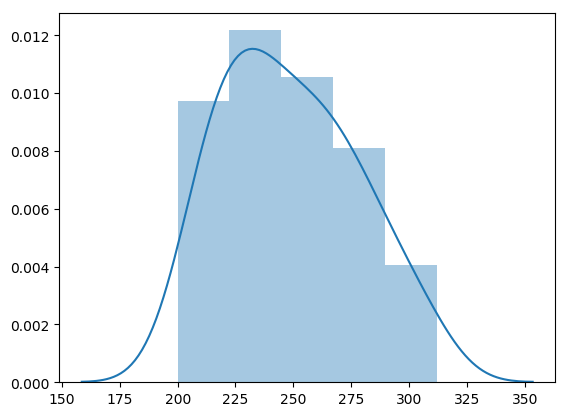

In [325]:
criticalEnergy = map(lambda x: x[0]*x[1],criticalRegion)
ax = sns.distplot(criticalEnergy)
print np.mean(criticalEnergy) , np.min(criticalEnergy), np.max(criticalEnergy),np.var(criticalEnergy)


In [318]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(budNets["Ligand Number"], bins)
binnedLigandNum = [budNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [nonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [budNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


In [319]:
def buildBinnedPlot(c):
    binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    return binnedBudC,binnedBudxErr,binnedBudyErr,binnedNoBudC,binnedNoBudxErr,binnedNoBudyErr

In [320]:
def buildHistPlot(c,n):
    budPop = criticalNets[(criticalNets['Mean Budding Time'] > 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    nonBudPop = criticalNets[(criticalNets['Mean Budding Time'] < 0.0)&(criticalNets['Ligand Number']==float(n))][c].values.tolist()
    return budPop, nonBudPop
    

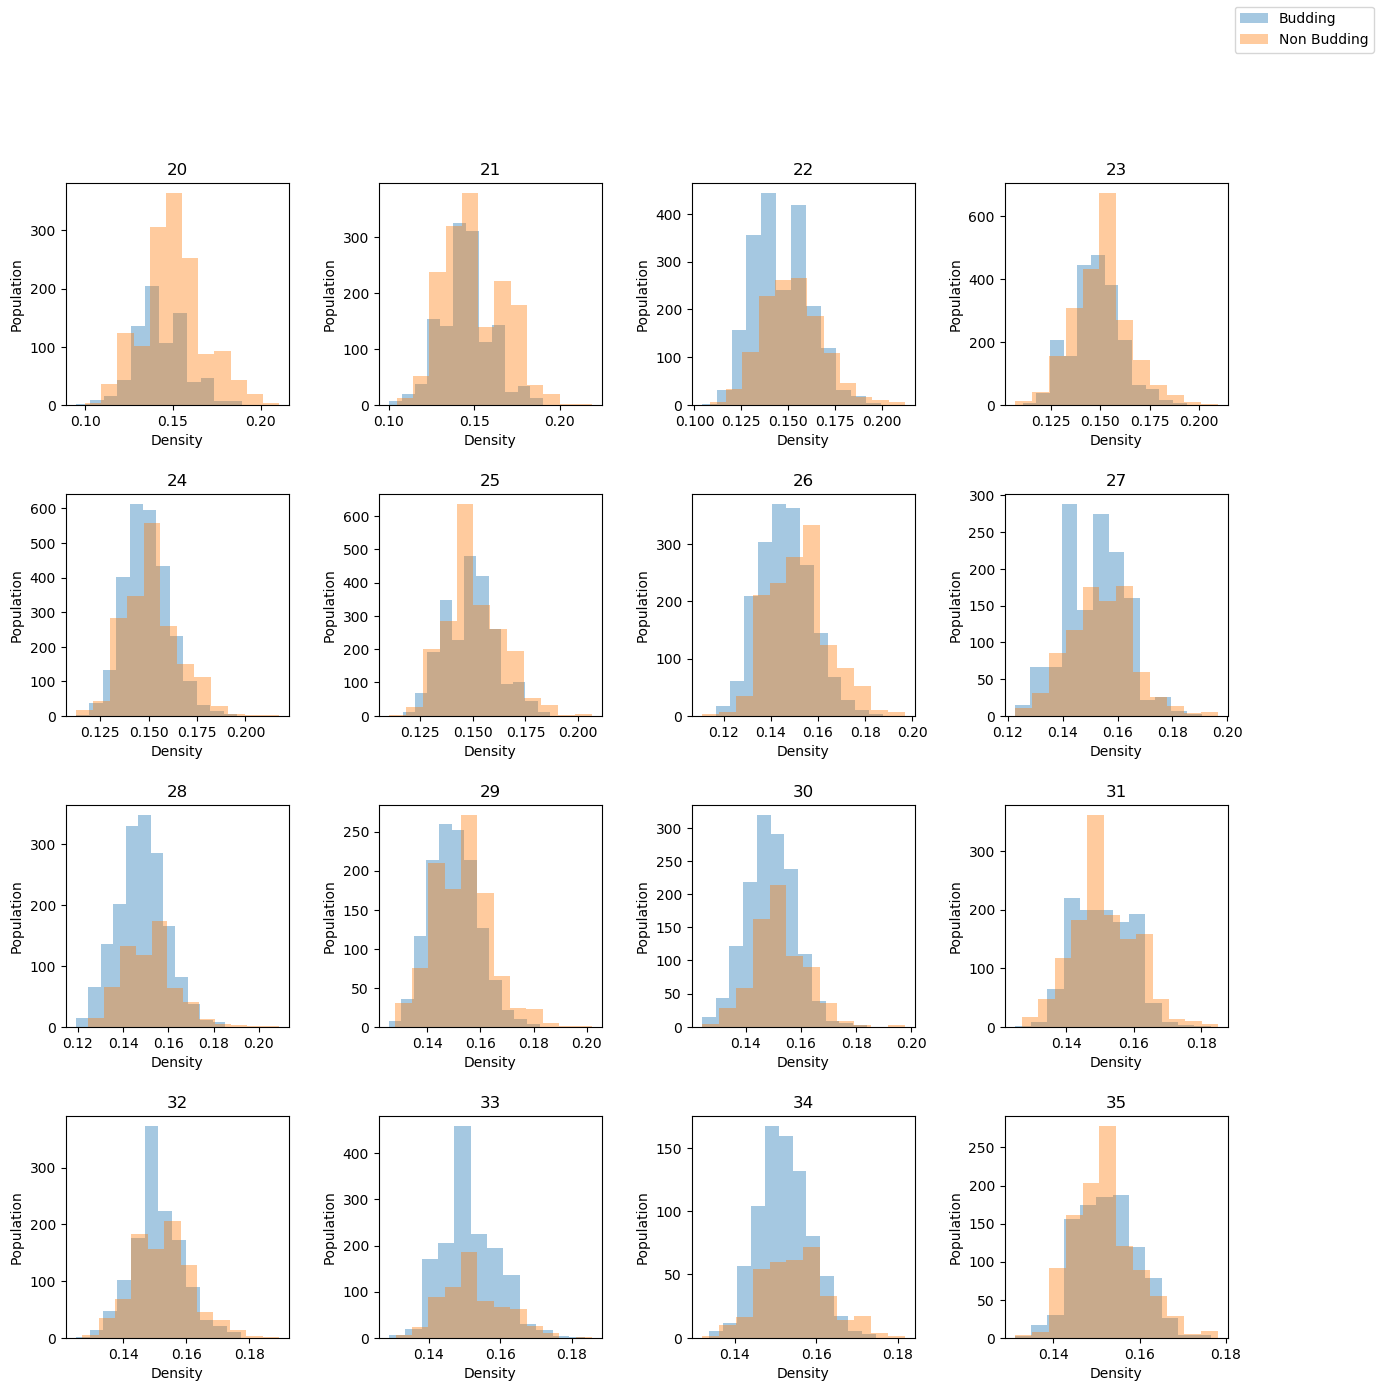

In [321]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
startI = 20
for i in range(startI,startI+16):
    ax = plt.subplot(4, 4, i-startI+1)
    r = buildHistPlot("Density",i)
    ax = sns.distplot(r[0],label="Budding",bins=12,kde=False)
    ax = sns.distplot(r[1],label="Non Budding",bins=12,kde=False)
    ax.set_xlabel("Density")
    ax.set_ylabel("Population")
    ax.set_title(i)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [330]:
def bigFig(c,label="NONE"):
    if label=="NONE":
        label = c
    plt.figure(figsize=(12,7.5))
    ax = plt.subplot(111)

    r = [int(np.floor(min(budNets[c])*1000)), int(np.ceil(max(budNets[c])*1000)+1)]
    # for y in range(r[0],r[1]):    
    #     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

    xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

    # for y in range(r[0],r[1]):    
    #     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    


    r = buildBinnedPlot(c)

#     plt.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
#     plt.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")

    plt.errorbar(binnedLigandNum,r[0],fmt='-o',label="Budding")
    plt.errorbar(binnedNonBudLigandNum,r[3],fmt='-o',label="Non Budding")

    yerrbud1 = [e[0]-e[1] for e in  zip(r[0],r[2])]
    yerrbud2 = [e[0]+e[1] for e in  zip(r[0],r[2])]

    yerrnobud1 = [e[0]-e[1] for e in  zip(r[3],r[5])]
    yerrnobud2 = [e[0]+e[1] for e in  zip(r[3],r[5])]

    ax.fill_between(binnedLigandNum,yerrbud1, yerrbud2, where=yerrbud2 >= yerrbud1, facecolor=tab20[1], interpolate=True,alpha=0.5)
    ax.fill_between(binnedLigandNum,yerrnobud1, yerrnobud2, where=yerrnobud2 >= yerrnobud1, facecolor=tab20[3], interpolate=True,alpha=0.5)


    plt.ylabel(label,fontsize=16)
    plt.xlabel("Ligand Number",fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False) 
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()   
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on")  
    plt.legend(loc='lower right',fontsize=12,bbox_to_anchor=(0.9, 0.1))
    plt.savefig('/Users/joel/Projects/Figures/eps/'+label+'-LigandNumber.eps', format='eps', dpi=1000)
    plt.savefig('/Users/joel/Projects/Figures/png/'+label+'-LigandNumber.png')
    plt.cla()
    plt.clf()

In [ ]:
for c in budNets.columns:
    f = bigFig(c)
plt.cla()
plt.clf()
plt.close()


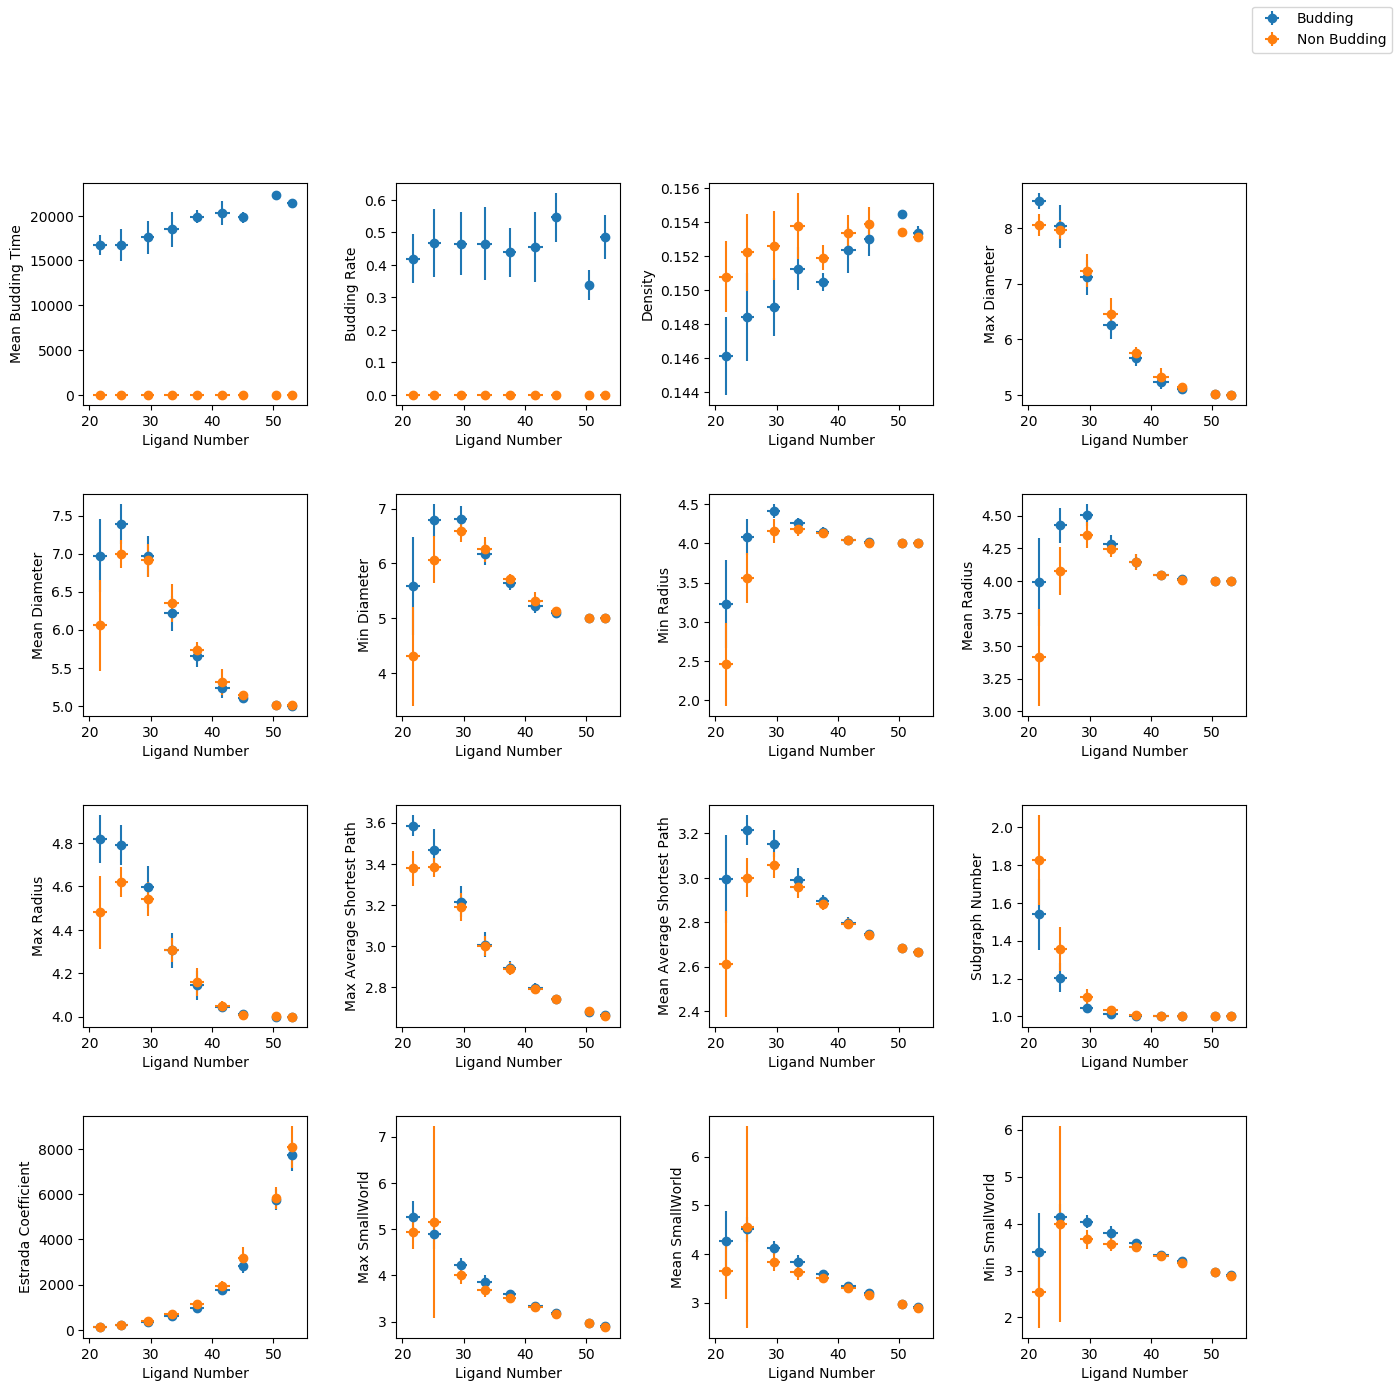

In [333]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
#     binnedBudC = [budNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedBudyErr = [b for b in [np.std(budNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudxErr = [b for b in [np.std(budNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
#     binnedNoBudC = [nonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
#     binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
#     binnedNoBudyErr = [b for b in [np.std(nonbudNets[c][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
#     binnedNoBudxErr = [b for b in [np.std(nonbudNets["Ligand Number"][digitisedLigandNum == b]) for b in range(1, len(bins))]if not np.isnan(b)]
    r = buildBinnedPlot(c)
    ax.errorbar(binnedLigandNum,r[0],xerr=r[1],yerr=r[2],fmt='o',label="Budding")
    ax.errorbar(binnedNonBudLigandNum,r[3],yerr=r[5],xerr=r[4],fmt='o',label="Non Budding")
    #ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

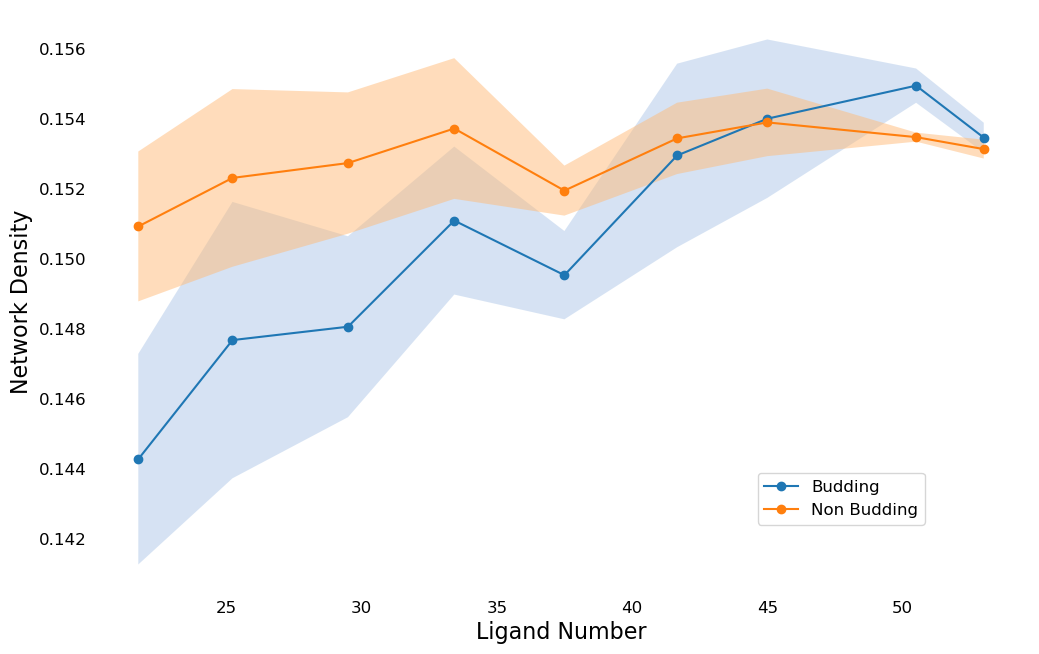

In [240]:
plt.figure(figsize=(12,7.5))
ax = plt.subplot(111)

r = [int(np.floor(min(budNets['Density'])*1000)), int(np.ceil(max(budNets['Density'])*1000)+1)]
# for y in range(r[0],r[1]):    
#     plt.plot(range(r[0],r[1]), [y] * len(range(r[0],r[1])), "--", lw=0.5, color="black", alpha=0.3)

xr = range(int(np.floor(min(budNets['Ligand Number']))-1), int(np.ceil(max(budNets['Ligand Number']))+2))

# for y in range(r[0],r[1]):    
#     plt.plot(xr, [y*0.001] * len(xr) , "--", lw=0.5, color="black", alpha=0.3)    
 
    
r = buildBinnedPlot("Density")

plt.errorbar(binnedLigandNum,r[0],fmt='-o',label="Budding")
plt.errorbar(binnedNonBudLigandNum,r[3],fmt='-o',label="Non Budding")

yerrbud1 = [e[0]-e[1] for e in  zip(r[0],r[2])]
yerrbud2 = [e[0]+e[1] for e in  zip(r[0],r[2])]

yerrnobud1 = [e[0]-e[1] for e in  zip(r[3],r[5])]
yerrnobud2 = [e[0]+e[1] for e in  zip(r[3],r[5])]

ax.fill_between(binnedLigandNum,yerrbud1, yerrbud2, where=yerrbud2 >= yerrbud1, facecolor=tab20[1], interpolate=True,alpha=0.5)
ax.fill_between(binnedLigandNum,yerrnobud1, yerrnobud2, where=yerrnobud2 >= yerrnobud1, facecolor=tab20[3], interpolate=True,alpha=0.5)

    
# plt.plot(budNets["Ligand Number"],budNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(3))
# plt.plot(nonbudNets["Ligand Number"],nonbudNets['Density'],'.',label='_nolegend_',alpha=0.5,color=plt.get_cmap('tab20')(1))
# plt.plot(meanBudNets["Ligand Number"],meanBudNets['Density'],'s',label="Budding",color=plt.get_cmap('tab20')(2))
# plt.plot(meanNonbudNets["Ligand Number"],meanNonbudNets['Density'],'s',label="Non Budding",alpha=0.5,color=plt.get_cmap('tab20')(0))
plt.ylabel("Network Density",fontsize=16)
plt.xlabel("Ligand Number",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  
plt.legend(loc='lower right',fontsize=12,bbox_to_anchor=(0.9, 0.1))
plt.savefig('/Users/joel/Projects/Figures/Density-LigandNumber.eps', format='eps', dpi=1000)
plt.savefig('/Users/joel/Projects/Figures/Density-LigandNumber.png')
plt.show()

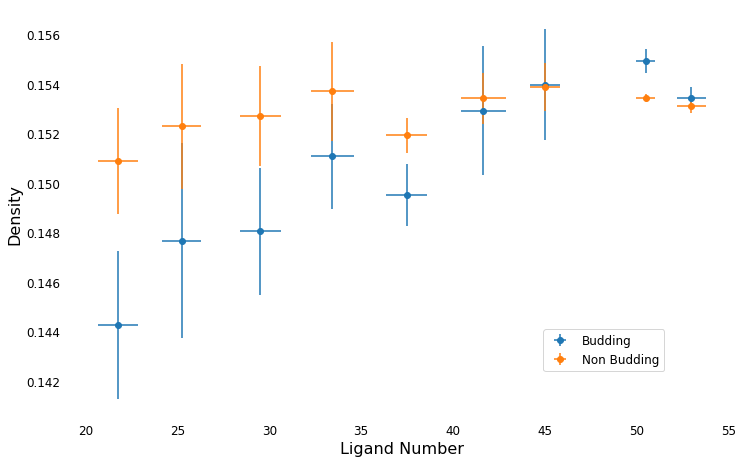

In [146]:
bigFig("Density")

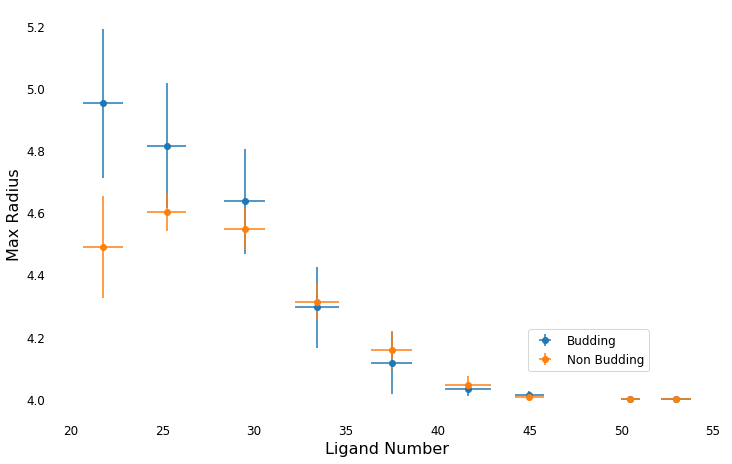

In [147]:
bigFig("Max Radius")

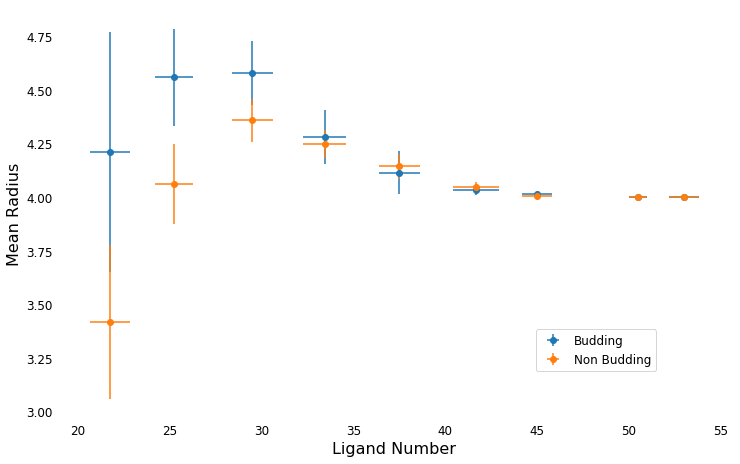

In [148]:
bigFig("Mean Radius")

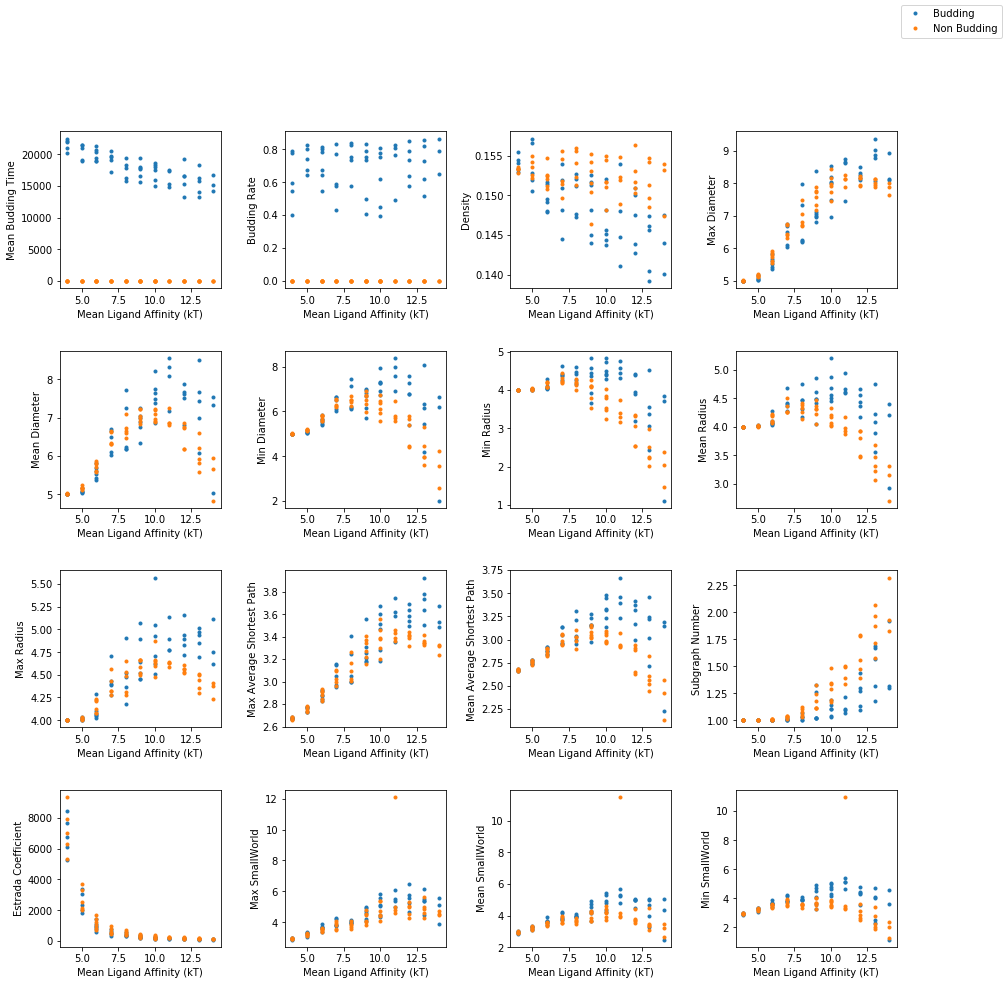

In [14]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

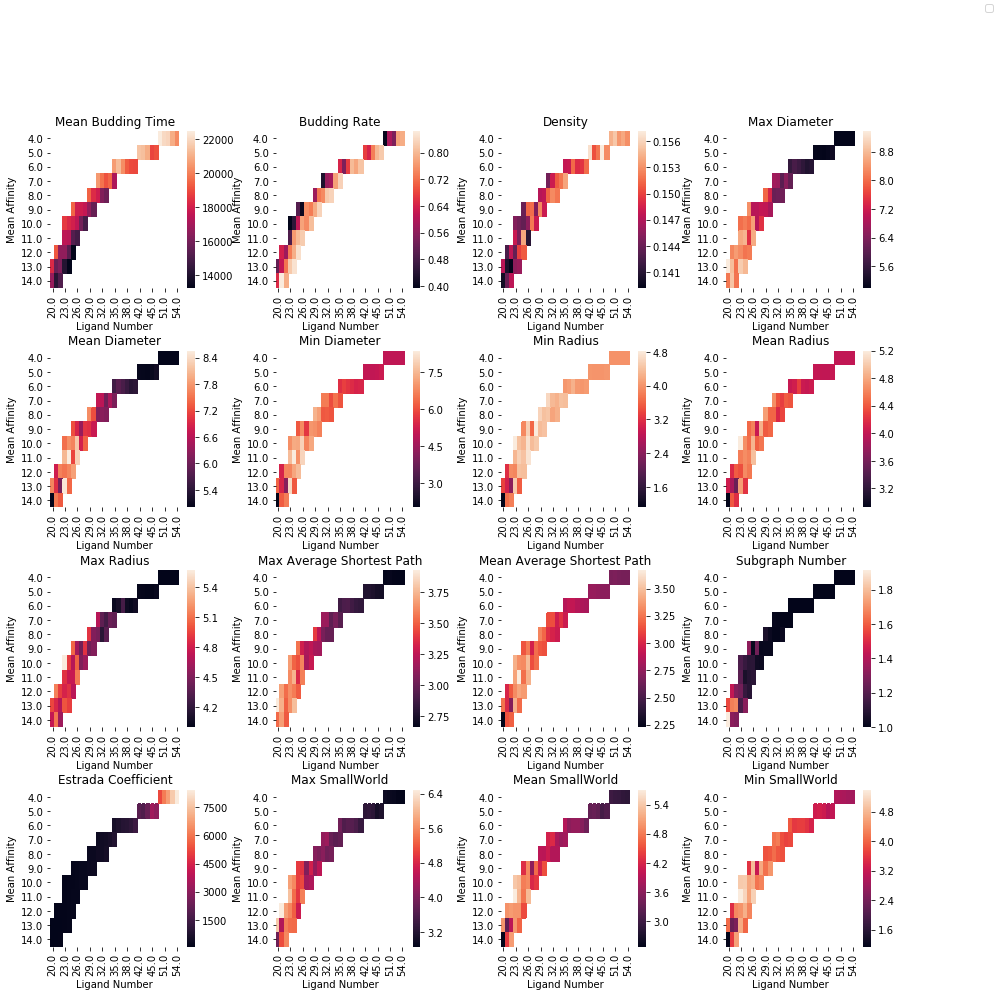

In [15]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    budNetsT = budNets.pivot("Mean Affinity", "Ligand Number", c)
    ax = sns.heatmap(budNetsT)
    ax.set_title(c)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

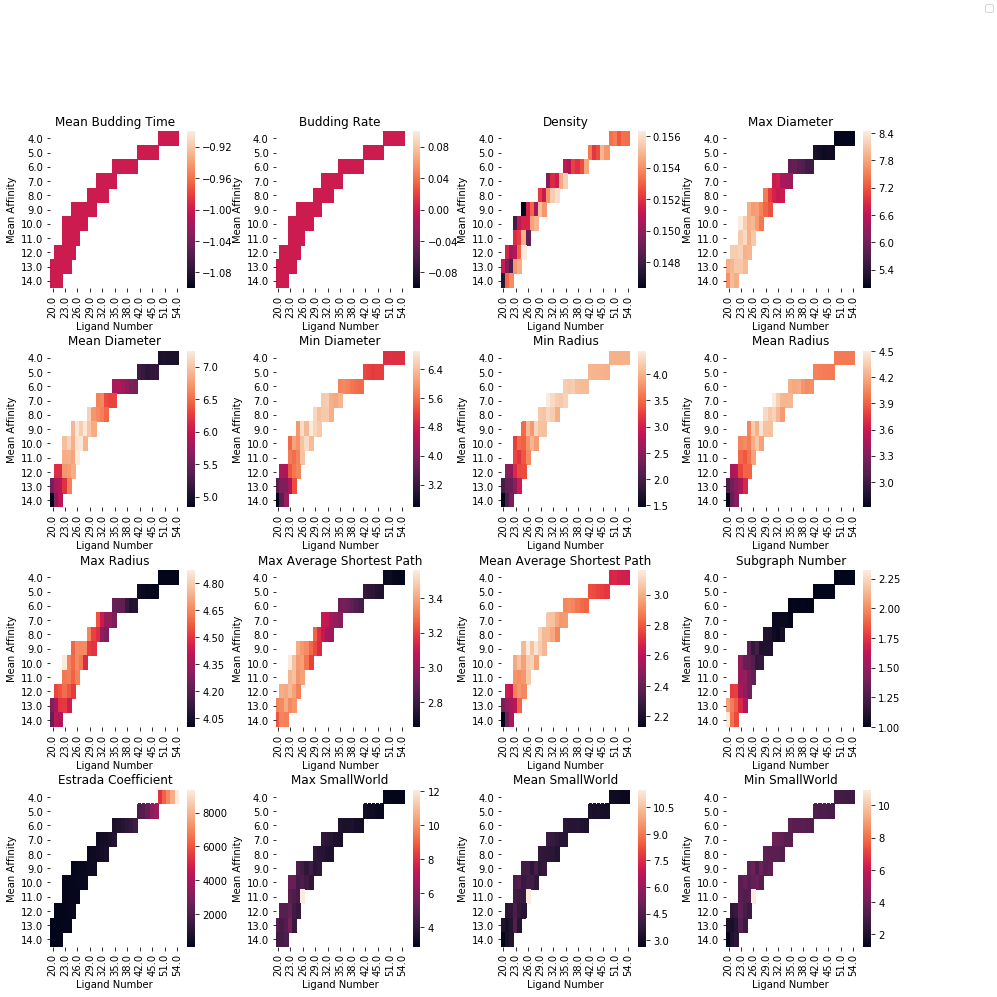

In [16]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    nonbudNetsT = nonbudNets.pivot("Mean Affinity", "Ligand Number", c)
    ax.set_title(c)
    ax = sns.heatmap(nonbudNetsT)
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [109]:
bins = np.linspace(0, 100, 26)
print bins

digitisedLigandNum = np.digitize(meanBudNets["Ligand Number"], bins)
binnedLigandNum = [meanBudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedNonBudLigandNum = [meanNonbudNets["Ligand Number"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]
binnedBuddingRate = [meanBudNets["Budding Rate"][digitisedLigandNum == i].mean() for i in range(1, len(bins))]

binnedLigandNum = [b for b in binnedLigandNum if not np.isnan(b)]
binnedNonBudLigandNum = [b for b in binnedNonBudLigandNum if not np.isnan(b)]
binnedBuddingRate = [b for b in binnedBuddingRate if not np.isnan(b)]


[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100.]


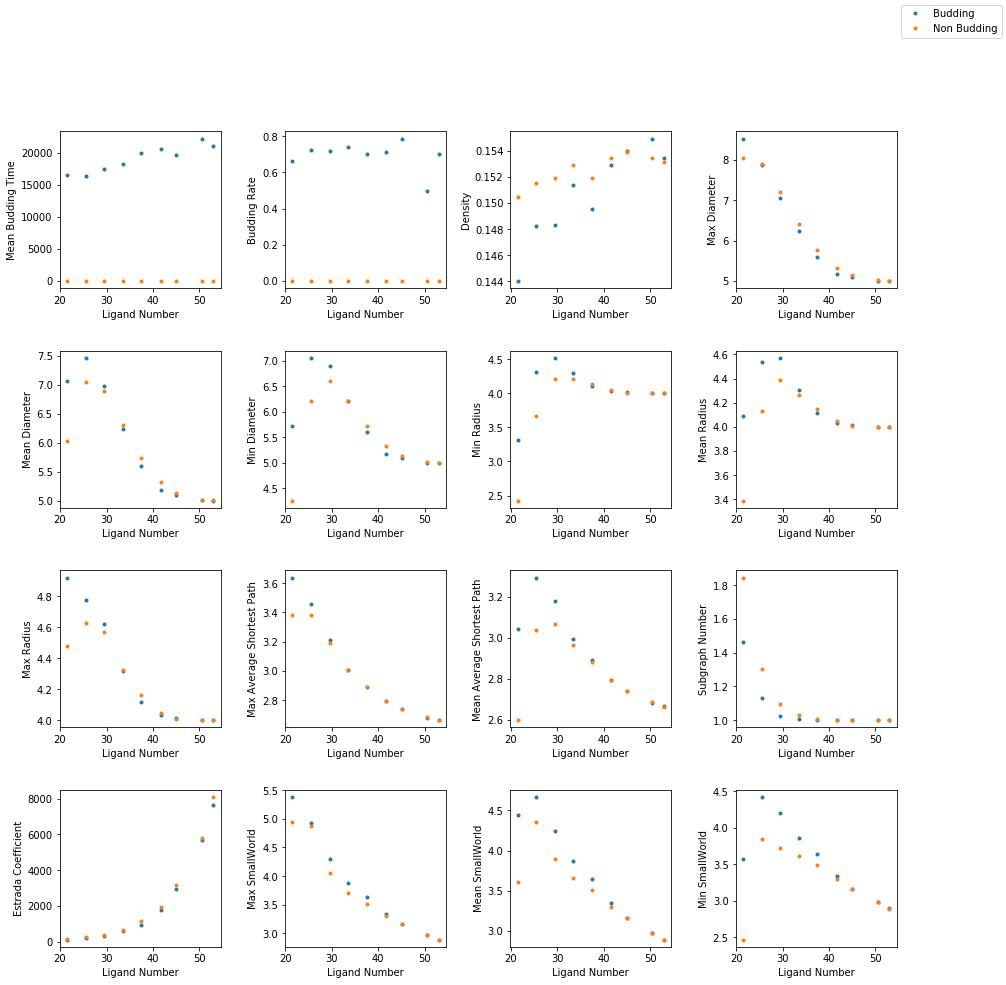

In [110]:
i = 1
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in meanBudNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    binnedBudC = [meanBudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedBudC = [b for b in binnedBudC if not np.isnan(b)]
    binnedNoBudC = [meanNonbudNets[c][digitisedLigandNum == b].mean() for b in range(1, len(bins))]
    binnedNoBudC = [b for b in binnedNoBudC if not np.isnan(b)]
    ax.plot(binnedLigandNum,binnedBudC,'.',label="Budding")
    ax.plot(binnedNonBudLigandNum,binnedNoBudC,'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Ligand Number")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

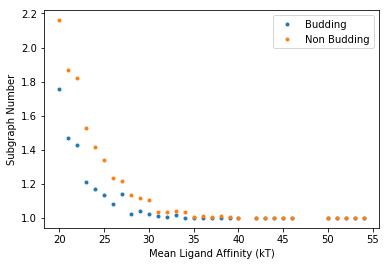

In [20]:
c = 'Subgraph Number'
plt.plot(meanBudNets['Ligand Number'],meanBudNets[c],'.',label="Budding")
plt.plot(meanNonbudNets['Ligand Number'],meanNonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [21]:
budNets = criticalNets[criticalNets['Mean Budding Time'] > 0.0].groupby(['Mean Affinity']).mean().reset_index()
nonbudNets = criticalNets[criticalNets['Mean Budding Time'] < 0.0].groupby(['Mean Affinity']).mean().reset_index()

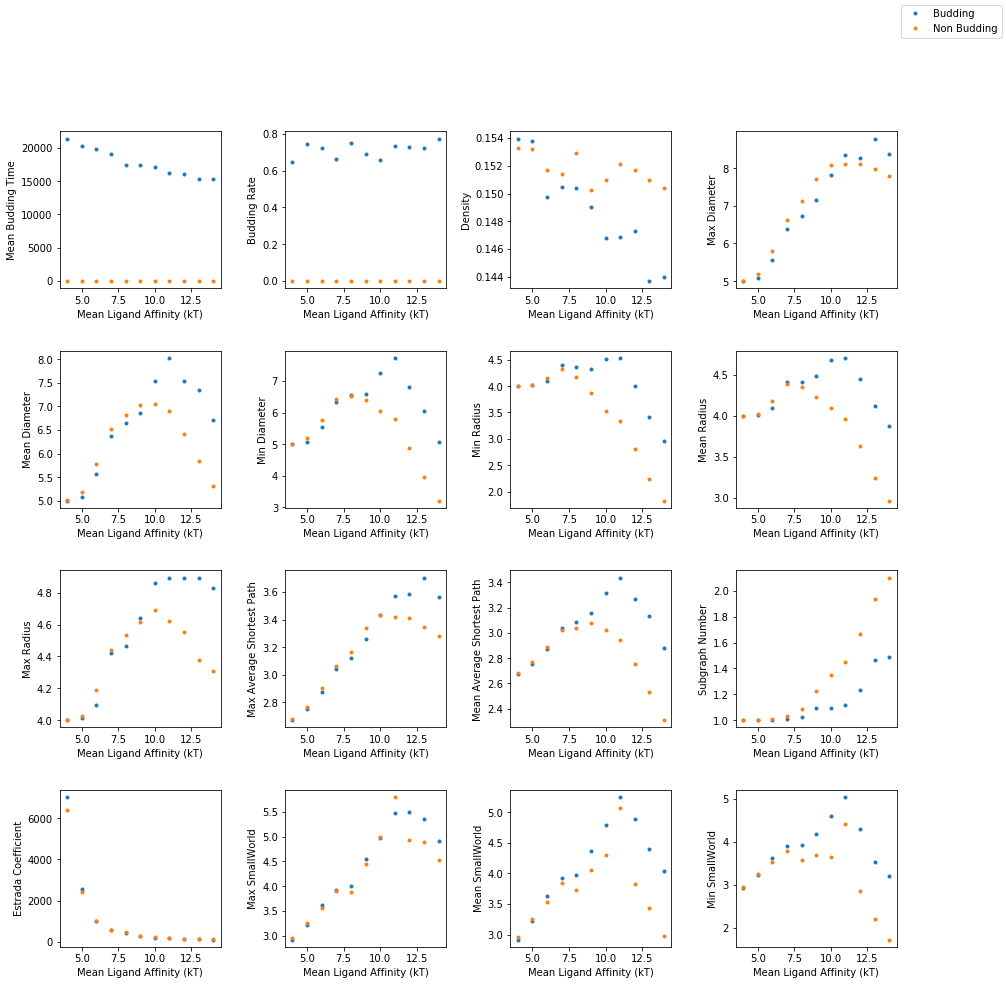

In [22]:
i = 1


fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(15)
for c in budNets.columns:
    if c in ['Pruning','Ligand Number','Mean Affinity',"Fitness","Min Average Shortest Path"]:
        continue
    ax = plt.subplot(4, 4, i)
    ax.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
    ax.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
    plt.ylabel(c)
    plt.xlabel("Mean Ligand Affinity (kT)")
    i+=1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

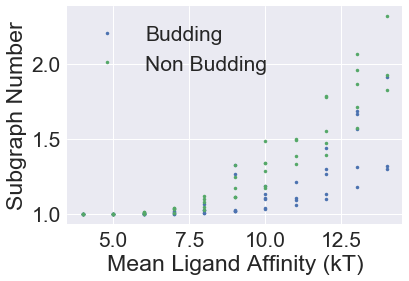

In [161]:
c = 'Subgraph Number'
plt.plot(budNets['Mean Affinity'],budNets[c],'.',label="Budding")
plt.plot(nonbudNets['Mean Affinity'],nonbudNets[c],'.',label="Non Budding")
plt.ylabel(c)
plt.xlabel("Mean Ligand Affinity (kT)")
plt.legend()
plt.show()

In [157]:
zoo_df = pd.read_csv('/Users/joel/Projects/golden/zoo.csv',names=['name','n','e','fitness','bud_rate','budtime'])

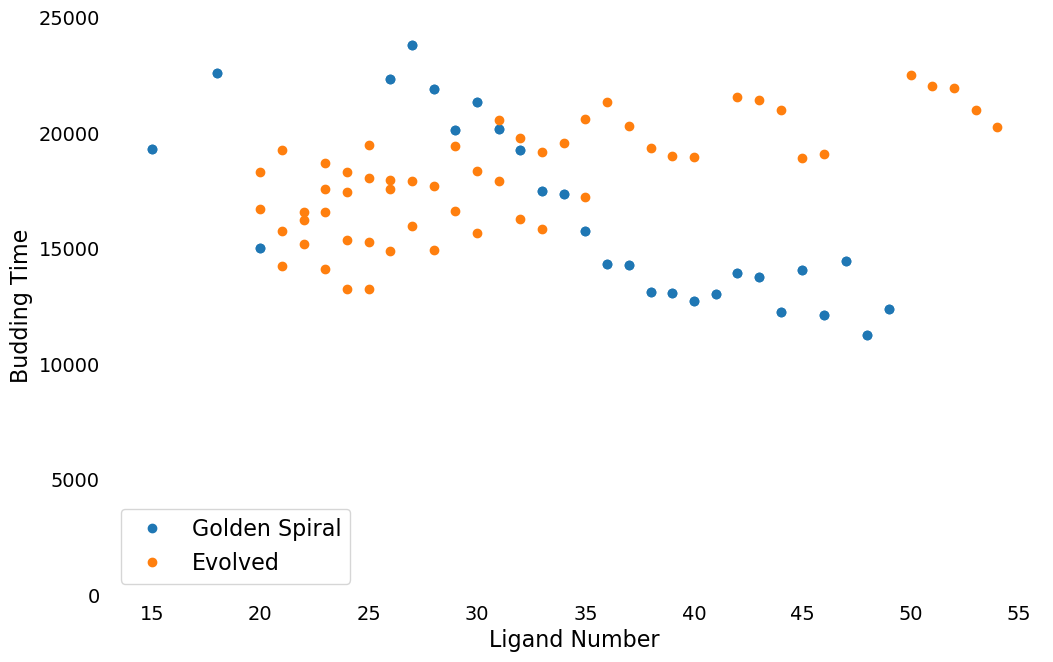

In [196]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
plt.figure(figsize=(12,7.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
plt.plot(zoo_df[zoo_df['budtime']>0]['n'],zoo_df[zoo_df['budtime']>0]['budtime'],'o',label="Golden Spiral")
plt.plot(budNets[budNets['Mean Budding Time']>0]['Ligand Number'],budNets[budNets['Mean Budding Time']>0]['Mean Budding Time'],'o',label="Evolved")
plt.ylabel('Budding Time',fontsize=16)
plt.xlabel("Ligand Number",fontsize=16)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
plt.ylim(0,25000)
plt.legend(fontsize=16)
plt.show()

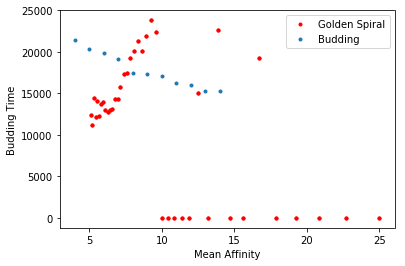

In [26]:
plt.plot(zoo_df['e'],zoo_df['budtime'],'.',label="Golden Spiral",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Mean Budding Time'],'.',label="Budding")
plt.ylabel('Budding Time')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

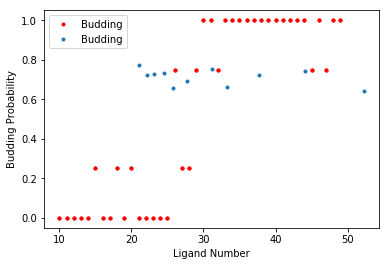

In [27]:
plt.plot(zoo_df['n'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Ligand Number'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Ligand Number")
plt.legend()
plt.show()

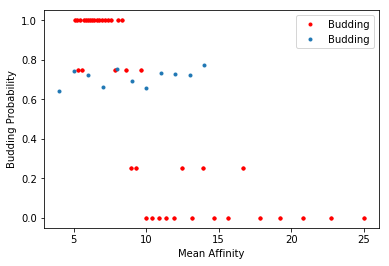

In [28]:
plt.plot(zoo_df['e'],zoo_df['bud_rate'],'.',label="Budding",color="red")
plt.plot(budNets['Mean Affinity'],budNets['Budding Rate'],'.',label="Budding")
plt.ylabel('Budding Probability')
plt.xlabel("Mean Affinity")
plt.legend()
plt.show()

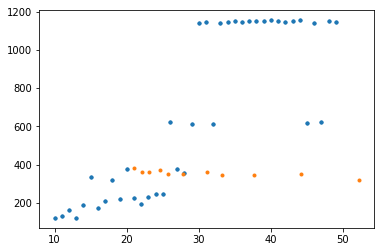

In [29]:
plt.plot(zoo_df['n'],zoo_df['fitness'],'.',label="Budding")
plt.plot(budNets['Ligand Number'],budNets['Fitness'],'.',label="Budding")

In [155]:
net_df[(net_df['Ligand Number']==23) & (net_df['Mean Affinity']==10)].sort_values("Subgraph Number")

,Ligand Number,Mean Affinity,Fitness,Mean Budding Time,Budding Rate,Density,Max Diameter,Mean Diameter,Min Diameter,Min Radius,...,Max Radius,Max Average Shortest Path,Mean Average Shortest Path,Min Average Shortest Path,Subgraph Number,Estrada Coefficient,Pruning,Max SmallWorld,Mean SmallWorld,Min SmallWorld
5760,23,10.0,205.000000,-1.0,0.00,0.146245,10,10.000000,10,5,...,5,3.806324,3.806324,3.806324,1,139.810574,0.3,3.887772,3.887772,3.887772
7598,23,10.0,257.171260,12300.0,0.25,0.154150,8,8.000000,8,5,...,5,3.426877,3.426877,3.426877,1,152.984219,0.3,4.498068,4.498068,4.498068
7599,23,10.0,282.464286,12300.0,0.25,0.154150,8,8.000000,8,5,...,5,3.426877,3.426877,3.426877,1,152.984219,0.3,6.117008,6.117008,6.117008
7601,23,10.0,423.178085,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,2.758783,2.758783,2.758783
7602,23,10.0,202.000000,-1.0,0.00,0.150198,8,8.000000,8,6,...,6,3.699605,3.699605,3.699605,1,137.310949,0.3,2.758107,2.758107,2.758107
7603,23,10.0,336.792756,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,2.247906,2.247906,2.247906
7604,23,10.0,386.634799,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,4.142526,4.142526,4.142526
7605,23,10.0,343.666851,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,11.704096,11.704096,11.704096
7607,23,10.0,339.886514,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,7.788684,7.788684,7.788684
7608,23,10.0,346.424294,18600.0,0.50,0.150198,8,8.000000,8,6,...,6,3.774704,3.774704,3.774704,1,131.029158,0.3,1.906552,1.906552,1.906552


In [148]:
net_df[(net_df['Fitness']==223.250000)& (net_df['Ligand Number']==23) & (net_df['Mean Affinity']==10) ].sort_values(["Subgraph Number","Density"])

,Ligand Number,Mean Affinity,Fitness,Mean Budding Time,Budding Rate,Density,Max Diameter,Mean Diameter,Min Diameter,Min Radius,...,Max Radius,Max Average Shortest Path,Mean Average Shortest Path,Min Average Shortest Path,Subgraph Number,Estrada Coefficient,Pruning,Max SmallWorld,Mean SmallWorld,Min SmallWorld
5835,23,10.0,223.25,-1.0,0.0,0.154150,8,8.0,8,4,...,4,3.197628,3.197628,3.197628,1,139.596948,0.3,10.370034,10.370034,10.370034
5905,23,10.0,223.25,-1.0,0.0,0.154150,8,8.0,8,4,...,4,3.197628,3.197628,3.197628,1,139.596948,0.3,5.499880,5.499880,5.499880
5918,23,10.0,223.25,-1.0,0.0,0.154150,8,8.0,8,4,...,4,3.197628,3.197628,3.197628,1,139.596948,0.3,3.042501,3.042501,3.042501
5792,23,10.0,223.25,-1.0,0.0,0.142292,6,5.0,4,2,...,3,2.536765,2.301716,2.066667,2,132.153117,0.3,4.192870,2.663024,1.133178
6697,23,10.0,223.25,-1.0,0.0,0.150198,10,5.5,1,1,...,5,3.795238,2.397619,1.000000,2,145.345806,0.3,2.177431,1.088715,0.000000


In [132]:
bud_df

,e,n,bud_number,size,bud_percentage,mean_budtime
0,20,4,0,2880,0.000000,-1.000000
1,20,5,0,2880,0.000000,-1.000000
2,20,6,0,2880,0.000000,-1.000000
3,20,7,0,2880,0.000000,-1.000000
4,20,8,0,2880,0.000000,-1.000000
5,20,9,0,2880,0.000000,-1.000000
6,20,11,205,2880,0.017795,22143.536585
7,20,12,1400,2880,0.184549,21427.216667
8,20,13,1806,2880,0.323003,18296.849022
9,20,14,2258,2880,0.511024,16715.756422


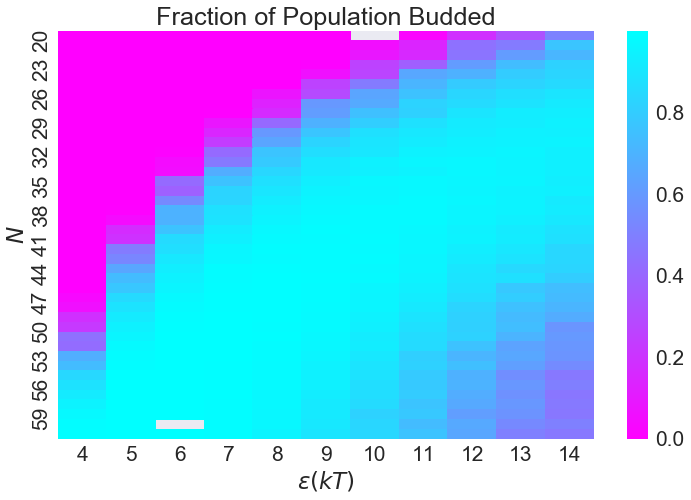

In [147]:
plt.figure(figsize=(12,7.5))
result = bud_df.pivot(index='e', columns='n', values='bud_percentage')
sns.heatmap(result,cmap='cool_r')
plt.title('Fraction of Population Budded')
plt.xlabel("$\epsilon (kT)$")
plt.ylabel("$N$")
sns.set(font_scale=2.1)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
    
plt.show()

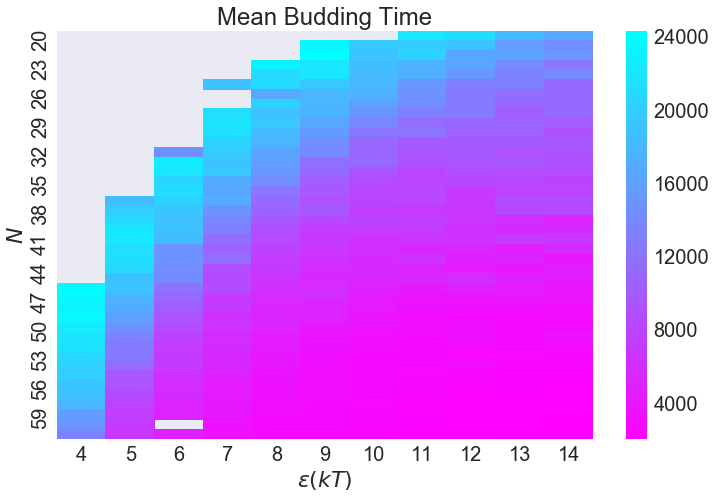

In [146]:
plt.figure(figsize=(12,7.5))
result = bud_df[bud_df['mean_budtime']>0].pivot(index='e', columns='n', values='mean_budtime')
sns.heatmap(result,cmap='cool_r')
plt.title('Mean Budding Time')
plt.xlabel("$\epsilon (kT)$")
plt.ylabel("$N$")
sns.set(font_scale=2.1)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
    
plt.show()

In [209]:
import random
for c in criticalNets:
    print c

Ligand Number
Mean Affinity
Fitness
Mean Budding Time
Budding Rate
Density
Max Diameter
Mean Diameter
Min Diameter
Min Radius
Mean Radius
Max Radius
Max Average Shortest Path
Mean Average Shortest Path
Min Average Shortest Path
Subgraph Number
Estrada Coefficient
Pruning
Max SmallWorld
Mean SmallWorld
Min SmallWorld
